In [30]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Optional, Tuple

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_analysis as pmanalysis
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1146
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

# Mimicing the CERES model in PyMC3

In this notebook, my goal is to mimic the CERES model using PyMC3.
I will take one shortcut and replace the piecewise linear spline regression to model the effect of copy number with just a single covariate and scale the copy number.

## Data preparation

In [31]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)

# Additional subsampling for testing purposes.
GENES = np.random.choice(data.hugo_symbol.unique(), 10)
CELLLINES = np.random.choice(data.depmap_id.unique(), 20)
data = data[data.hugo_symbol.isin(GENES)]
data = data[data.depmap_id.isin(CELLLINES)]

data = data.sort_values(["hugo_symbol", "sgrna", "depmap_id"]).reset_index(drop=True)
for col in ("hugo_symbol", "depmap_id", "sgrna", "lineage", "chromosome"):
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data["log2_cn"] = np.log2(data.gene_cn + 1)
data = dphelp.zscale_cna_by_group(
    data,
    gene_cn_col="log2_cn",
    new_col="z_log2_cn",
    groupby="depmap_id",
    cn_max=np.log2(10),
)
data["is_mutated"] = dphelp.nmutations_to_binary_array(data.n_muts)

## Modeling

In [32]:
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
cell_idx, num_cells = dphelp.get_indices_and_count(data, "depmap_id")

In [47]:
with pm.Model() as ceres_m1:

    # Indices
    sgrna_idx_shared = pm.Data("sgrna_idx_shared", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx_shared", gene_idx)
    cell_idx_shared = pm.Data("cell_idx_shared", cell_idx)

    # Data
    C_shared = pm.Data("C", data.z_log2_cn.to_numpy())
    lfc_shared = pm.Data("lfc", data.lfc.to_numpy())

    # Priors
    q = pm.Beta("q", 3, 3, shape=num_sgrnas)
    h = pm.Normal("h", 0, 2, shape=num_genes)
    g = pm.Normal("g", 0, 2, shape=(num_genes, num_cells))
    β = pm.Normal("β", -0.2, 1, shape=num_cells)
    o = pm.Normal("o", 0, 1, shape=num_sgrnas)

    # Linear model
    μ = pm.Deterministic(
        "μ",
        q[sgrna_idx_shared] * (h[gene_idx_shared] + g[gene_idx_shared, cell_idx_shared])
        + β[cell_idx_shared] * C_shared
        + o[sgrna_idx_shared],
    )
    σ = pm.HalfNormal("σ", 3)

    # Likelihood
    D = pm.Normal("D", μ, σ, observed=lfc_shared)

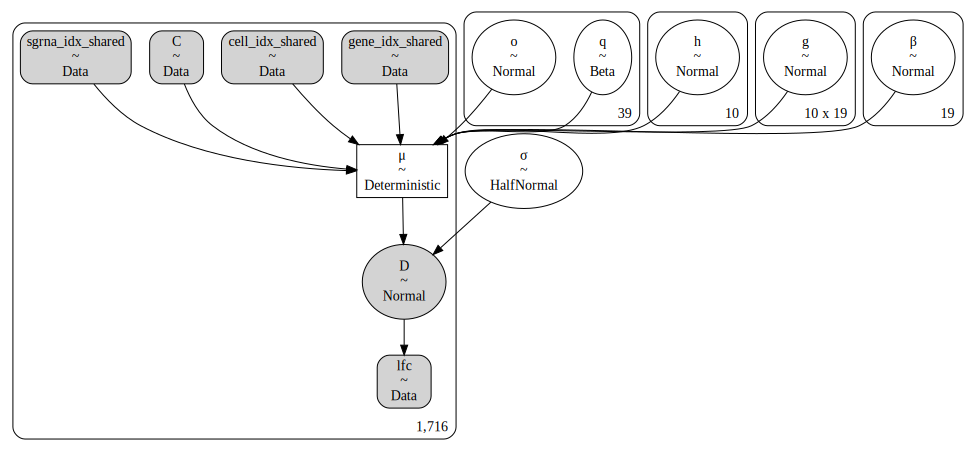

In [48]:
pm.model_to_graphviz(ceres_m1)

In [49]:
m1_cache_dir = pymc3_cache_dir / "mimic-ceres2_m1"

m1_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=ceres_m1,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=m1_cache_dir,
    force=True,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 200000, "target_accept": 0.9},
)

ceres_m1_az = pmhelp.samples_to_arviz(model=ceres_m1, res=m1_sampling_results)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 28800
Interrupted at 28,799 [14%]: Average Loss = 1,511.2
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, o, β, g, h, q]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 213 seconds.


Caching trace and posterior sample...


posterior predictive variable D's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


In [50]:
h_post_summary = az.summary(ceres_m1_az, hdi_prob=0.89, var_names="h")
h_post_summary[["hugo_symbol"]] = data.hugo_symbol.values.categories
h_post_summary.head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,hugo_symbol
h[0],-0.320,1.796,-3.004,2.755,0.046,0.039,1515.0,1044.0,1513.0,1219.0,1.0,CXCL2
h[1],-0.367,1.651,-3.112,2.091,0.039,0.038,1830.0,946.0,1823.0,1312.0,1.0,DPH7
h[2],-0.099,1.726,-3.012,2.644,0.046,0.038,1379.0,1058.0,1387.0,1134.0,1.0,GHSR
h[3],0.056,1.816,-2.750,3.024,0.045,0.043,1645.0,887.0,1649.0,1289.0,1.0,HIST1H2BO
h[4],-1.022,1.365,-3.246,1.192,0.034,0.030,1658.0,1063.0,1657.0,1172.0,1.0,NDUFAF3


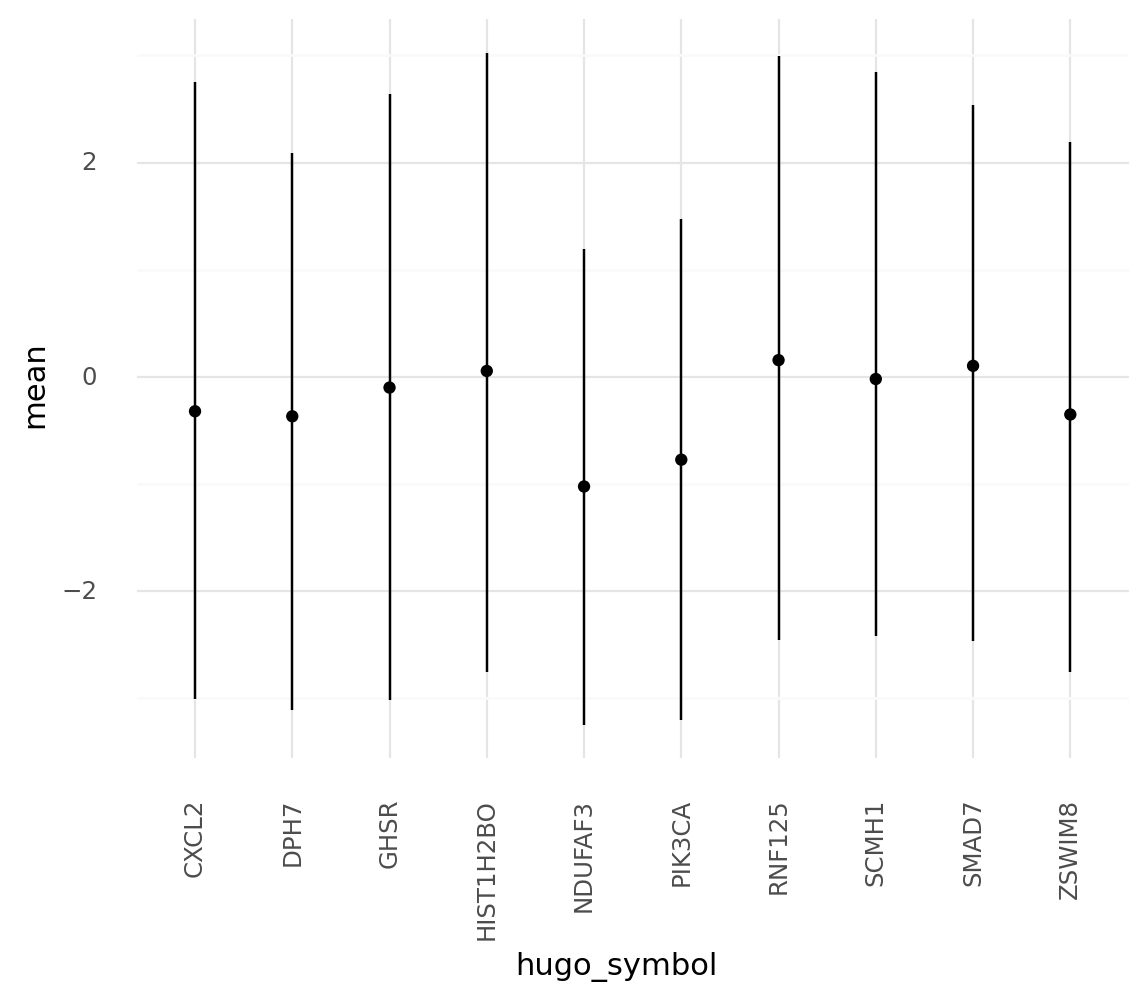

<ggplot: (8768128396508)>

In [51]:
(
    gg.ggplot(h_post_summary, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_point()
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.theme(axis_text_x=gg.element_text(angle=90))
)

In [52]:
g_post_summary = (
    az.summary(ceres_m1_az, hdi_prob=0.89, var_names="g", kind="stats")
    .reset_index(drop=False)
    .rename(columns={"index": "g_kj"})
)

g_post_summary = pmanalysis.extract_matrix_variable_indices(
    g_post_summary,
    col="g_kj",
    idx1=data.hugo_symbol.values.categories,
    idx2=data.depmap_id.values.categories,
    idx1name="hugo_symbol",
    idx2name="depmap_id",
)

g_post_summary.head()

,g_kj,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"g[0,0]",-2.006,1.007,-3.418,-0.201,CXCL2,ACH-000007
1,"g[0,1]",-0.150,1.018,-1.828,1.340,CXCL2,ACH-000217
2,"g[0,2]",-0.156,0.877,-1.626,1.136,CXCL2,ACH-000243
3,"g[0,3]",1.041,0.996,-0.534,2.656,CXCL2,ACH-000244
4,"g[0,4]",0.627,0.990,-1.063,2.138,CXCL2,ACH-000261


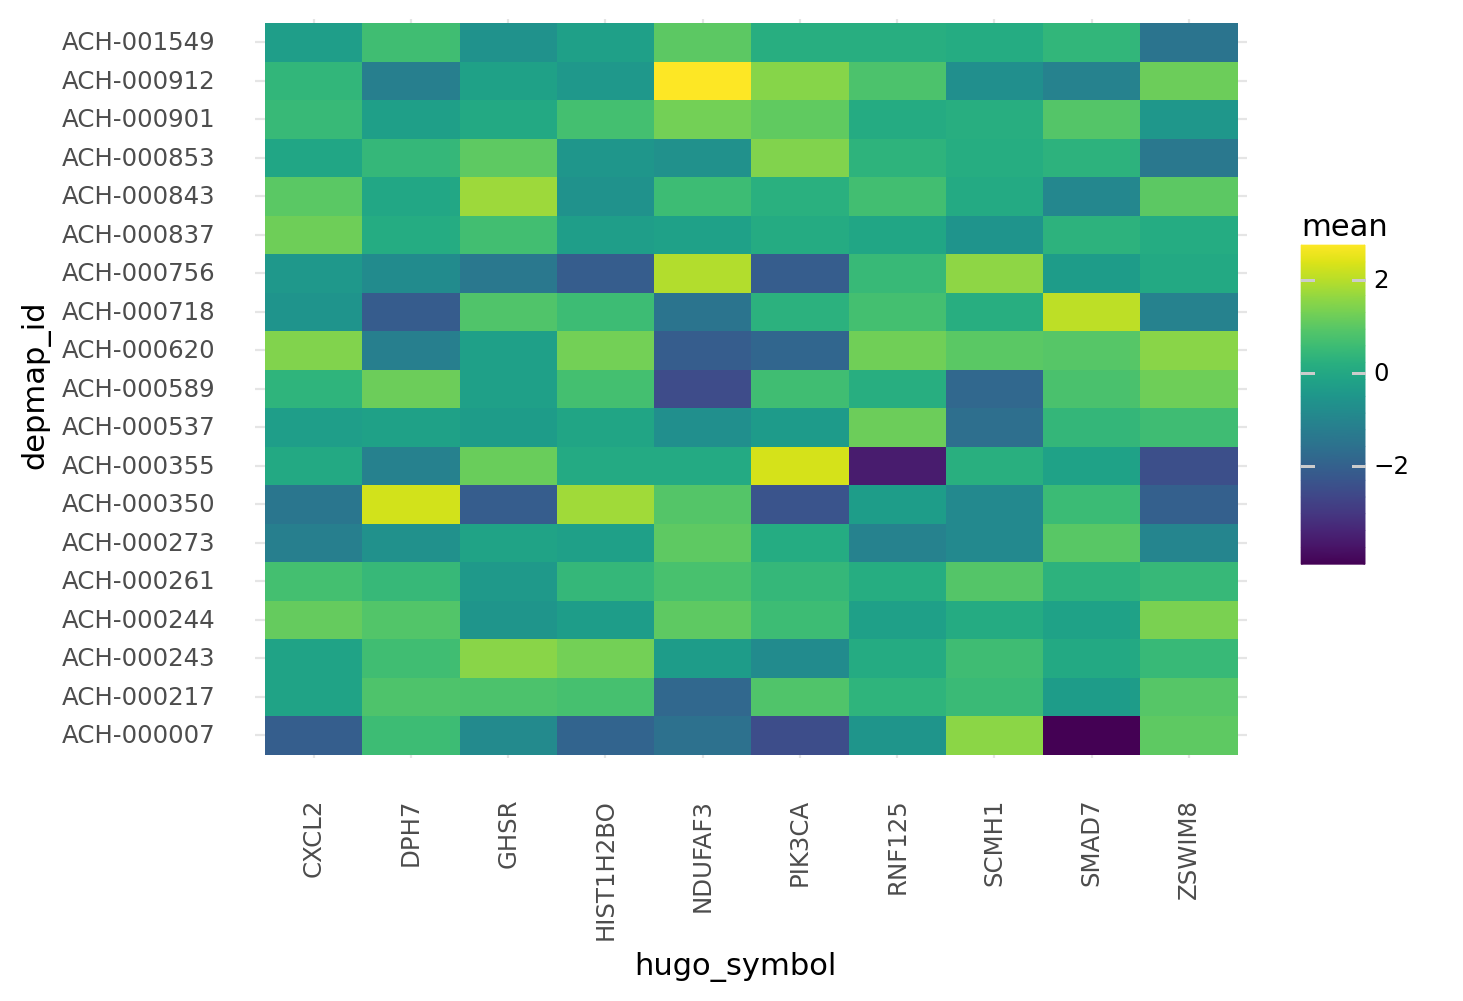

<ggplot: (8768084924688)>

In [53]:
(
    gg.ggplot(g_post_summary, gg.aes(x="hugo_symbol", y="depmap_id"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.theme(axis_text_x=gg.element_text(angle=90), axis_text_y=gg.element_text())
)

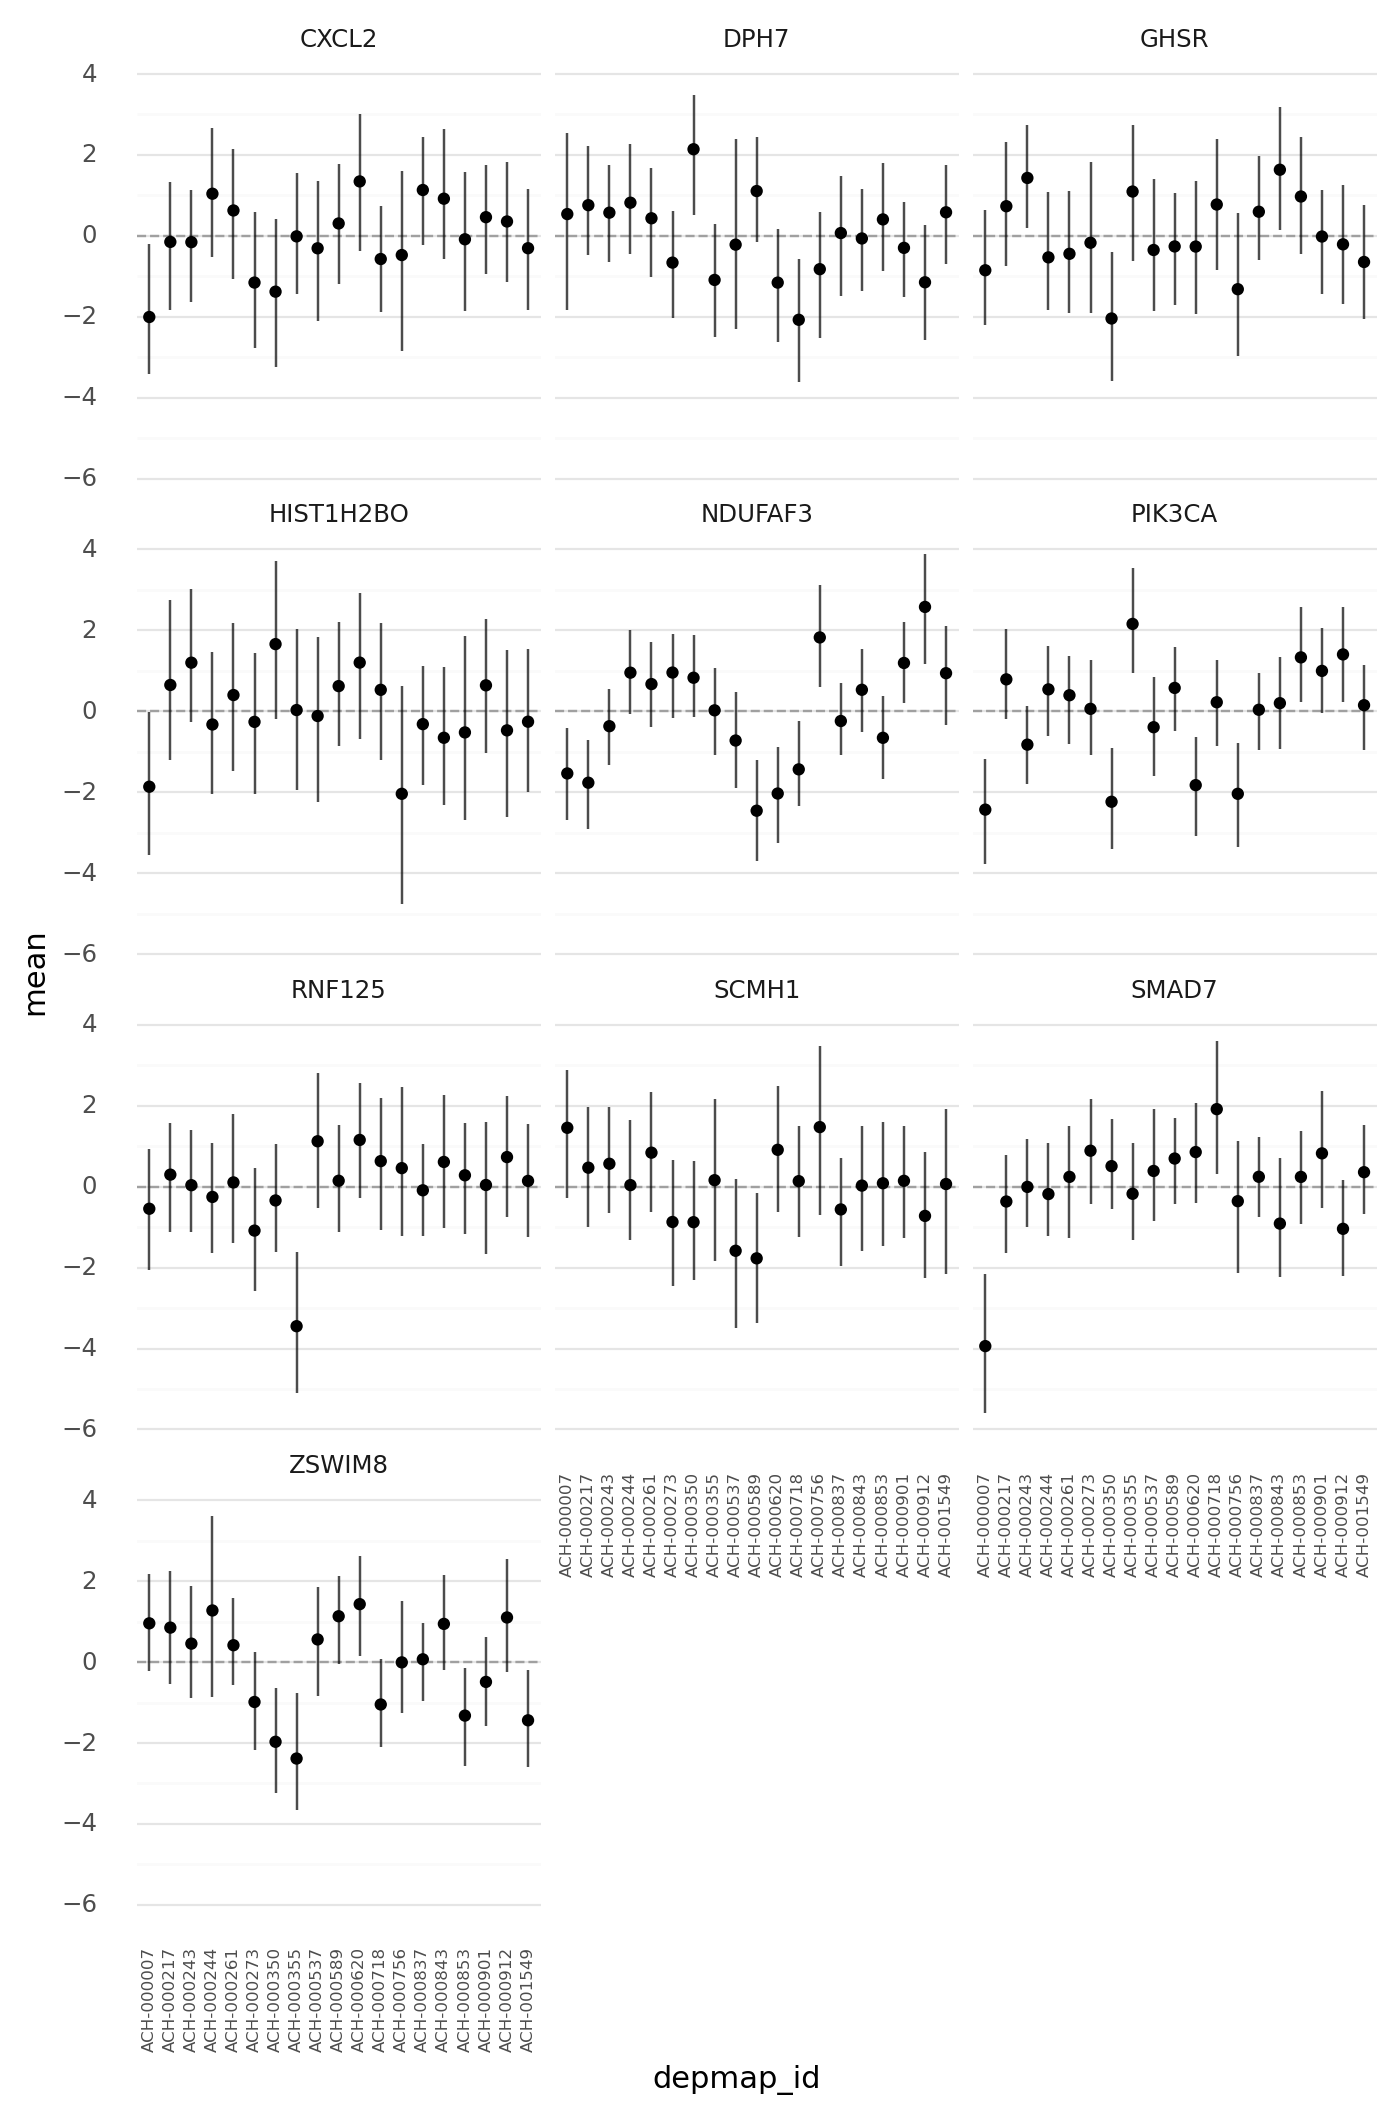

<ggplot: (8768085708135)>

In [54]:
pos = gg.position_dodge(width=0.7)
(
    gg.ggplot(g_post_summary, gg.aes(x="depmap_id"))
    + gg.facet_wrap("hugo_symbol", ncol=3)
    + gg.geom_hline(yintercept=0, color="black", alpha=0.3, linetype="--")
    + gg.geom_point(gg.aes(y="mean"), position=pos, color="black")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"),
        position=pos,
        color="black",
        alpha=0.7,
    )
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=6),
        figure_size=(8, 12),
        panel_grid_major_x=gg.element_blank(),
    )
)

In [55]:
beta_post_summary = az.summary(ceres_m1_az, var_names="β", hdi_prob=0.89, kind="stats")
beta_post_summary[["depmap_id"]] = data.depmap_id.values.categories
beta_post_summary.head()

,mean,sd,hdi_5.5%,hdi_94.5%,depmap_id
β[0],-0.068,0.084,-0.194,0.067,ACH-000007
β[1],-0.024,0.076,-0.144,0.096,ACH-000217
β[2],-0.115,0.074,-0.237,0.000,ACH-000243
β[3],0.037,0.106,-0.133,0.195,ACH-000244
β[4],-0.023,0.075,-0.149,0.089,ACH-000261


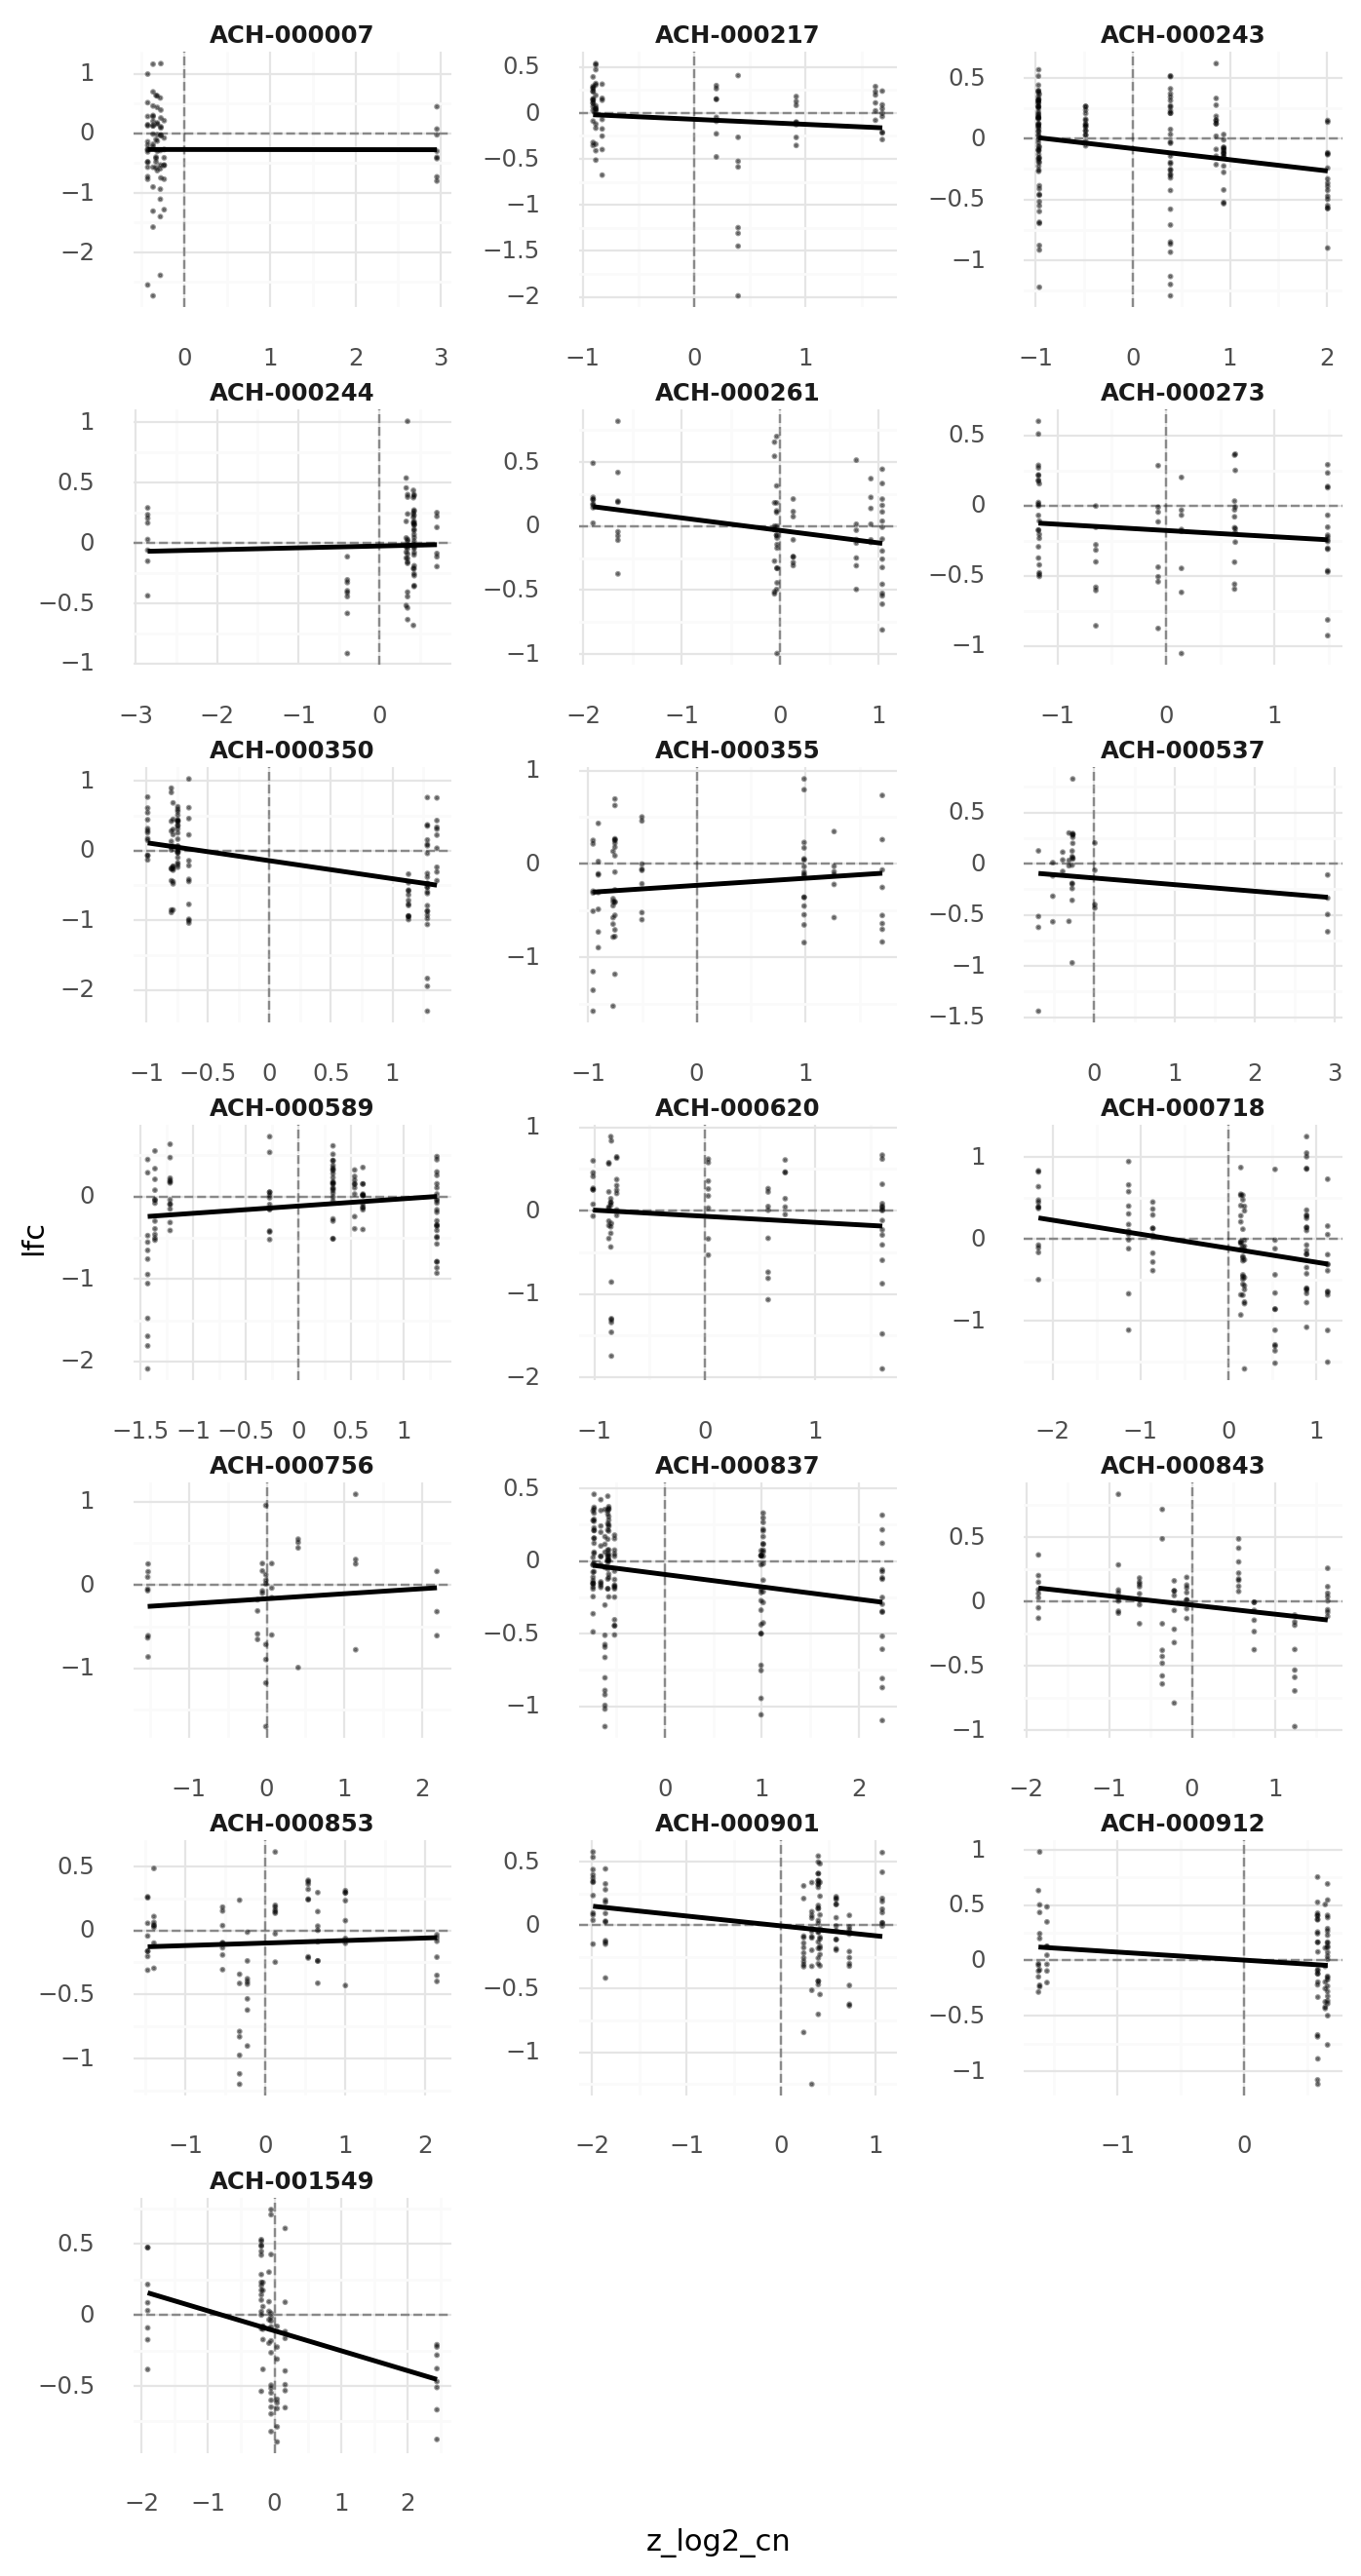

<ggplot: (8768085743903)>

In [58]:
(
    gg.ggplot(data, gg.aes(x="z_log2_cn", y="lfc"))
    + gg.facet_wrap("depmap_id", ncol=3, scales="free")
    + gg.geom_vline(xintercept=0, color="black", alpha=0.4, linetype="--")
    + gg.geom_hline(yintercept=0, color="black", alpha=0.4, linetype="--")
    + gg.geom_point(alpha=0.4, size=0.2)
    + gg.geom_smooth(formula="y~x", method="lm", se=False)
    + gg.theme(
        figure_size=(8, 16),
        subplots_adjust={"hspace": 0.4, "wspace": 0.4},
        strip_text=gg.element_text(weight="bold"),
    )
)

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


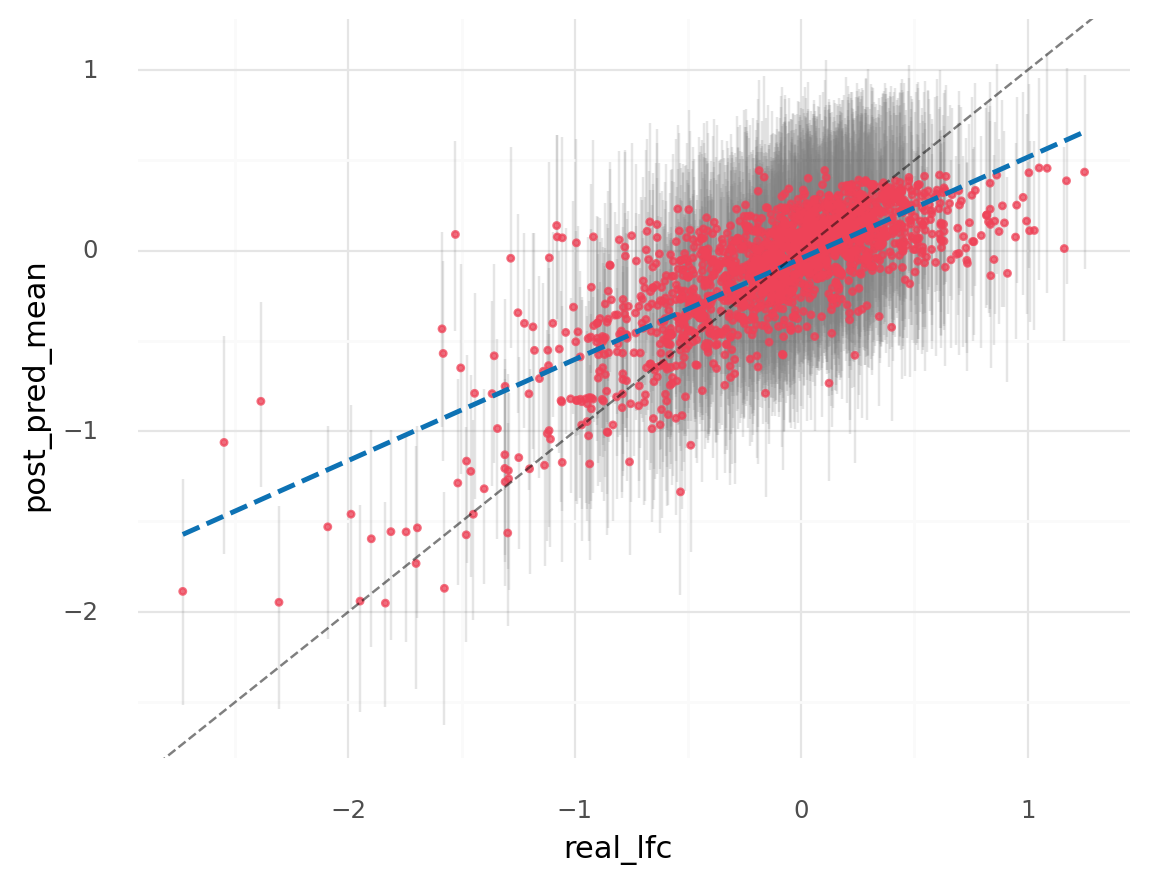

<ggplot: (8768157574919)>

In [88]:
# TODO: turn this into a function for `pymc3_analysis.py`.

m1_ppc_mean = np.mean(m1_sampling_results["posterior_predictive"]["D"], axis=0)
m1_ppc_hdi = az.hdi(m1_sampling_results["posterior_predictive"]["D"], hdi_prob=0.89)

ppc_df = pd.DataFrame(
    {
        "post_pred_mean": m1_ppc_mean,
        "post_pred_hdi_5.5%": m1_ppc_hdi[:, 0],
        "post_pred_hdi_94.5%": m1_ppc_hdi[:, 1],
        "real_lfc": data.lfc,
    }
)

(
    gg.ggplot(ppc_df, gg.aes(x="real_lfc", y="post_pred_mean"))
    + gg.geom_linerange(
        gg.aes(ymin="post_pred_hdi_5.5%", ymax="post_pred_hdi_94.5%"),
        alpha=0.2,
        size=0.5,
        color="gray",
    )
    + gg.geom_point(size=0.8, alpha=0.75, color="#EF4358")
    + gg.geom_smooth(
        formula="y~x", method="lm", se=False, color="#0D72B4", alpha=0.75, linetype="--"
    )
    + gg.geom_abline(slope=1, intercept=0, color="black", linetype="--", alpha=0.5)
)

---

In [71]:
sgrna_idx, num_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
gene_idx, num_genes = dphelp.get_indices_and_count(data, "hugo_symbol")
cell_idx, num_cells = dphelp.get_indices_and_count(data, "depmap_id")

# sgrna_to_gene_map = (
#     data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
# )
# sgrna_to_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")

In [72]:
with pm.Model() as ceres_m2:

    # Indices
    sgrna_idx_shared = pm.Data("sgrna_idx_shared", sgrna_idx)
    gene_idx_shared = pm.Data("gene_idx_shared", gene_idx)
    cell_idx_shared = pm.Data("cell_idx_shared", cell_idx)

    # Data
    C_shared = pm.Data("C", data.z_log2_cn.to_numpy())
    lfc_shared = pm.Data("lfc", data.lfc.to_numpy())

    # Hyper-priors
    a_q = pm.Exponential("q_a", 2)
    b_q = pm.Exponential("q_b", 1)

    μ_h = pm.Normal("μ_h", 0, 0.5)
    σ_h = pm.HalfNormal("σ_h", 1)

    μ_g = pm.Normal("μ_g", 0, 0.5)
    σ_g = pm.HalfNormal("σ_g", 1)

    μ_β = pm.Normal("μ_β", -0.2, 1)
    σ_β = pm.HalfNormal("σ_β", 1)

    μ_o = pm.Normal("μ_o", 0, 0.5)
    σ_o = pm.HalfNormal("σ_o", 0.2)

    # Priors
    q = pm.Beta("q", a_q, b_q, shape=num_sgrnas)
    h = pm.Normal("h", μ_h, σ_h, shape=num_genes)
    g = pm.Normal("g", μ_g, σ_g, shape=(num_genes, num_cells))
    β = pm.Normal("β", μ_β, σ_β, shape=num_cells)
    o = pm.Normal("o", μ_o, σ_o, shape=num_sgrnas)

    # Linear model
    μ = pm.Deterministic(
        "μ",
        q[sgrna_idx_shared] * (h[gene_idx_shared] + g[gene_idx_shared, cell_idx_shared])
        + β[cell_idx_shared] * C_shared
        + o[sgrna_idx_shared],
    )
    σ = pm.HalfNormal("σ", 3)

    # Likelihood
    D = pm.Normal("D", μ, σ, observed=lfc_shared)

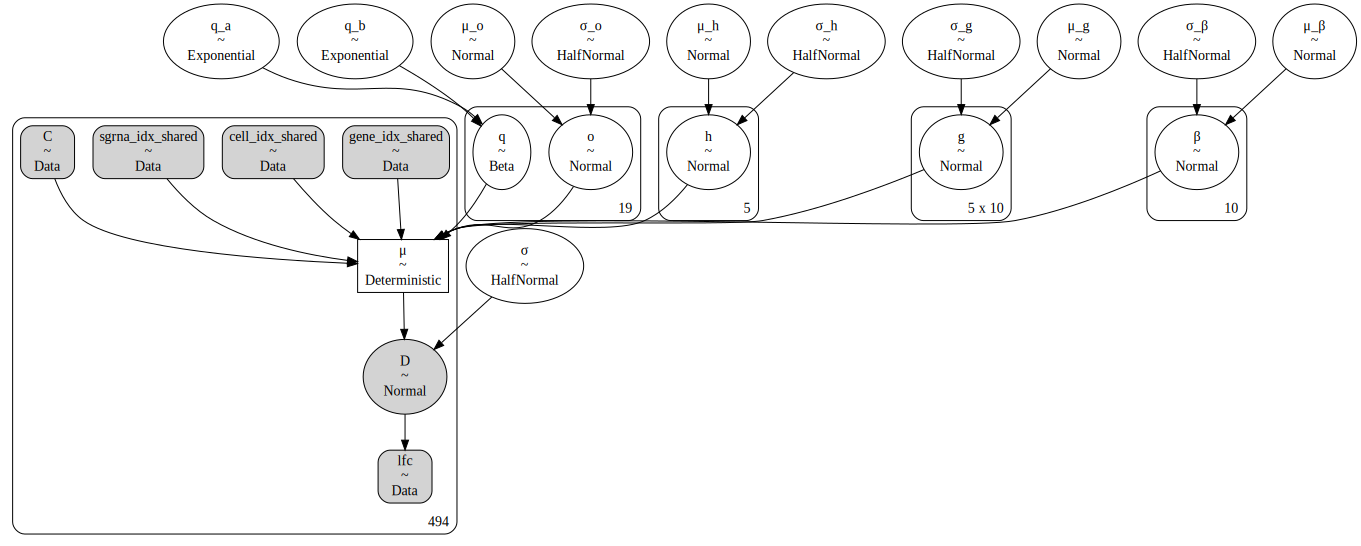

In [73]:
pm.model_to_graphviz(ceres_m2)

In [74]:
m2_cache_dir = pymc3_cache_dir / "mimic-ceres2_m2"

m2_sampling_results = pmhelp.pymc3_sampling_procedure(
    model=ceres_m2,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=m2_cache_dir,
    force=True,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 200000, "target_accept": 0.9},
)

ceres_m2_az = pmhelp.samples_to_arviz(model=ceres_m2, res=m2_sampling_results)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 24800
Interrupted at 24,799 [12%]: Average Loss = 506.98
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, o, β, g, h, q, σ_o, μ_o, σ_β, μ_β, σ_g, μ_g, σ_h, μ_h, q_b, q_a]


Sampling 2 chains for 1_000 tune and 614 draw iterations (2_000 + 1_228 draws total) took 64 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Caching trace and posterior sample...


OSError: [Errno 39] Directory not empty: '0'

---

In [50]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 10.63 minutes


In [51]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

plotnine 0.7.1
pandas   1.1.3
seaborn  0.11.0
re       2.2.1
numpy    1.19.2
pymc3    3.9.3
arviz    0.10.0
last updated: 2020-12-17 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
host name  : compute-a-16-78.o2.rc.hms.harvard.edu
Git branch : subset-data
